In [1]:
# Some final variables
imageSize = 224
batch_size = 128

In [2]:
from keras.preprocessing import image

def readImage(path):
    img = image.load_img(path, target_size=(imageSize, imageSize))
    x = image.img_to_array(img)
    x = x.astype('float32')
    x /= 255.0
    return x

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
def getLabel(path):
    name = path[path.rfind('/') + 1:path.index('.')]
#     print (name)
    return 1 if name == 'dog' else 0

In [4]:
from keras.applications.resnet50 import ResNet50

model = ResNet50(weights='imagenet')

In [5]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

def getPreds(img_path):
    img = image.load_img(img_path, target_size=(imageSize, imageSize))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    result = decode_predictions(preds, top=50)[0]
#     print('Predicted:', result)
    return result

In [6]:
dogs = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978']

cats=[
'n02123045','n02123159','n02123394','n02123597'
,'n02124075','n02125311','n02127052']

def isCat(preds):
    for item in preds:
        if item[0] in cats:
            return True
    return False
def isDog(preds):
    for item in preds:
        if item[0] in dogs:
            return True
    return False
def isValid(img_path):
    label = getLabel(img_path)
    preds = getPreds(img_path)
    return {
        0:isCat(preds),
        1:isDog(preds)
    }[label]

In [7]:
# Preprocess pics
import helper


train_dir = 'train/'
valid_files = []
invalid_files = []
train_files = helper.get_train_files()
train_files = sorted(train_files, key=lambda s: (len(s), s))

print(str(len(train_files)) + " need to preprocess")

for i in range(len(train_files)):
    file = train_files[i]
    print (file, end='\r')
    if isValid(file):
        valid_files.append(file)
    else:
        invalid_files.append(file)

print (str(len(valid_files)) + " files valid\n")
print (str(len(invalid_files)) + " invalid files as below:\n", end='\r')
# print (invalid_files)

25000 need to preprocess
24836 files validCatVsDog/train/dog.12499.jpg

164 invalid files as below:


In [8]:
def readFeatureAndLabel(valid_files):
    file_count = len(valid_files)
    print("readFeatureAndLabel file_count=" + str(file_count))
    train_feature = []
    train_label = []
    for i in range(file_count):
        f = train_files[i]
#         print (f)
        train_feature.append(readImage(f))
        train_label.append(getLabel(f))
    
    return train_feature, train_label

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

total_feature, total_label = readFeatureAndLabel(valid_files)
total_feature = np.array(total_feature)

total_label = np.array(total_label)

train_feature, validation_feature, train_label, validation_label = train_test_split(total_feature, total_label, test_size=0.1, random_state=1)

readFeatureAndLabel file_count=24836


In [15]:
# Plan C

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
# x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# optimizer='rmsprop'
# , beta_1=0.9, beta_2=0.999, epsilon=1e-08
opt = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_feature, train_label, batch_size=batch_size, epochs=30, validation_data=(validation_feature, validation_label))

Train on 22352 samples, validate on 2484 samples
Epoch 1/30
22352/22352 [==============================] - 41s 2ms/step - loss: 0.3170 - acc: 0.8888 - val_loss: 0.0712 - val_acc: 0.9754
Epoch 2/30
22352/22352 [==============================] - 37s 2ms/step - loss: 0.1807 - acc: 0.9369 - val_loss: 0.0497 - val_acc: 0.9807
Epoch 3/30
22352/22352 [==============================] - 37s 2ms/step - loss: 0.1556 - acc: 0.9439 - val_loss: 0.0613 - val_acc: 0.9791
Epoch 4/30
22352/22352 [==============================] - 37s 2ms/step - loss: 0.1420 - acc: 0.9464 - val_loss: 0.0683 - val_acc: 0.9767
Epoch 5/30
22352/22352 [==============================] - 37s 2ms/step - loss: 0.1354 - acc: 0.9481 - val_loss: 0.0552 - val_acc: 0.9807
Epoch 6/30
22352/22352 [==============================] - 37s 2ms/step - loss: 0.1306 - acc: 0.9492 - val_loss: 0.0566 - val_acc: 0.9811
Epoch 7/30
22352/22352 [==============================] - 37s 2ms/step - loss: 0.1230 - acc: 0.9528 - val_loss: 0.0491 - val_acc:

In [16]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True


# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
# loss='sparse_categorical_crossentropy'
from keras.optimizers import SGD
# Adam(lr=0.001)
opt2 = SGD(lr=0.0006, momentum=0.99, decay=0.00002, nesterov=True)
model.compile(optimizer=opt2, loss='binary_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history2 = model.fit(train_feature, train_label, batch_size=batch_size, epochs=24, validation_data=(validation_feature, validation_label), class_weight='auto')

Train on 22352 samples, validate on 2484 samples
Epoch 1/24
22352/22352 [==============================] - 45s 2ms/step - loss: 0.0837 - acc: 0.9664 - val_loss: 0.0350 - val_acc: 0.9895
Epoch 2/24
22352/22352 [==============================] - 40s 2ms/step - loss: 0.0181 - acc: 0.9951 - val_loss: 0.0305 - val_acc: 0.9903
Epoch 3/24
22352/22352 [==============================] - 40s 2ms/step - loss: 0.0061 - acc: 0.9985 - val_loss: 0.0341 - val_acc: 0.9899
Epoch 4/24
22352/22352 [==============================] - 40s 2ms/step - loss: 0.0030 - acc: 0.9995 - val_loss: 0.0345 - val_acc: 0.9907
Epoch 5/24
22352/22352 [==============================] - 40s 2ms/step - loss: 0.0016 - acc: 0.9999 - val_loss: 0.0323 - val_acc: 0.9915
Epoch 6/24
22352/22352 [==============================] - 40s 2ms/step - loss: 0.0012 - acc: 0.9999 - val_loss: 0.0336 - val_acc: 0.9907
Epoch 7/24
22352/22352 [==============================] - 40s 2ms/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0336 - val_acc:

Text(0.5,1,'Accuracy Curves')

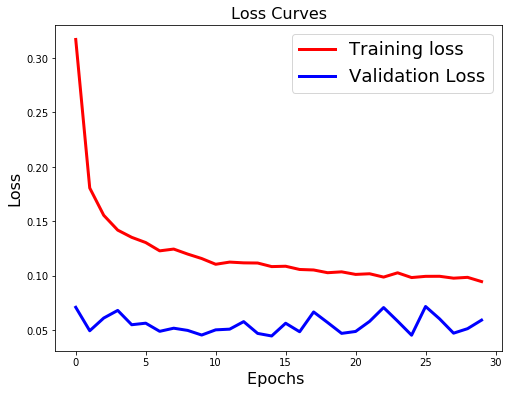

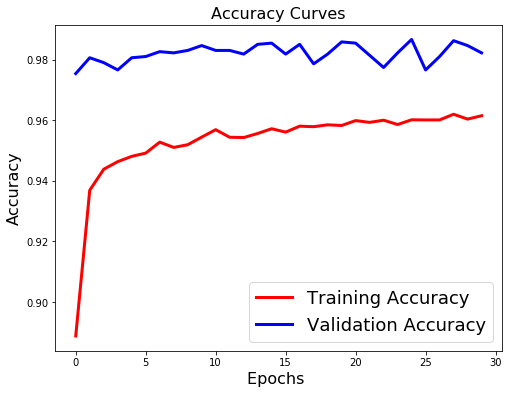

In [17]:
# show history

import matplotlib.pyplot as plt

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

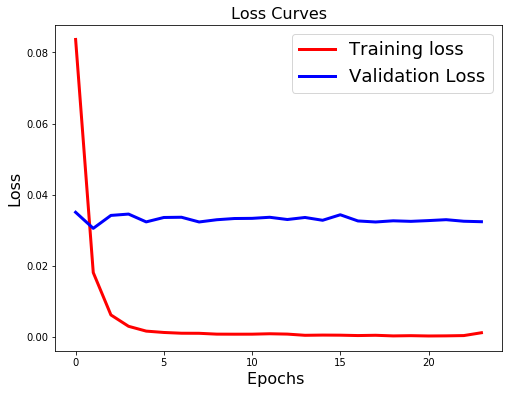

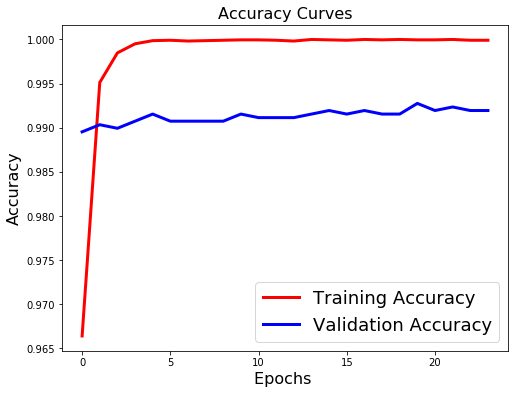

In [18]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history2.history['loss'],'r',linewidth=3.0)
plt.plot(history2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history2.history['acc'],'r',linewidth=3.0)
plt.plot(history2.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [19]:
import math

def score_fun(label_pre):
    total_score = 0
    size = validation_label.size
    for i in range(size):
        y = validation_label[i]
        yp = label_pre[i]
#         print (str(y) + " " + str(yp))
        try:
            total_score = y * math.log(yp) + (1 - y)*math.log(1-yp)
        except:
            print (str(i) + ": " + str(y) + " - " + str(yp))
    return -total_score/size
print("done")

done


In [21]:
val_label_pre = model.predict(validation_feature)
val_label_pre = np.clip(val_label_pre, 0.000001, 0.999999)
score = score_fun(val_label_pre)
print (score)

4.079224937798366e-10


In [24]:
# Predict for test data

import helper

test_files = helper.get_test_files()
test_files = sorted(test_files, key=lambda s: (len(s), s))

test_file_size = len(test_files)

test_feature = []
for i in range(test_file_size):
    test_feature.append(readImage(test_files[i]))
test_feature = np.asarray(test_feature)
print(type(test_feature))
test_label = model.predict(test_feature, batch_size=batch_size)
print (len(test_label))

<class 'numpy.ndarray'>
12500


In [28]:
# Write out predict data to csv

test_label_output = []
test_label_clip = np.clip(test_label, 0.1, 0.9)
for i in range(len(test_label_clip)):
    test_label_output.append([i + 1, test_label_clip[i]])
    
print (len(test_label_output))
test_label_output = np.array(test_label_output)
np.savetxt("submission.csv", test_label_output, fmt='%d,%f', delimiter=',', header="id,label", comments="")
print('done')

12500
done
